## UHF Coefficient Matrix Trials
RHF and UHF self-consistent methods require an initial guess of the coeeficient matrix (transforms basis orbitals to molecular orbitals).

In [13]:
import numpy as np
from scipy.linalg import expm
from pyscf import gto, scf, fci

# Create a stretched/dissociated hydrogen molecule
bond_length = 5
mol = gto.Mole()
mol.atom = f"H 0 0 0; H 0 0 {bond_length}"  # in Angstrom by default
mol.basis = "STO-3G"  # minimal basis, 1s from each H atom, two molecular orbitals
mol.charge = 0
mol.spin = 0  # number of unpaired electrons: 0 => singlet (default)
mol.verbose = 3  # print the converged energy and spin information
mol.build()

# Restricted Hartree-Fock (RHF)
# Number of alpha and beta spins in each orbital are equal
mf_rhf = scf.RHF(mol)  # create meanfield object
mf_rhf.kernel()  # run RHF

# Unrestricted Hartree-Fock (UHF)
# Number of alpha and beta spins in each orbital can differ
mf_uhf = scf.UHF(mol)  # create meanfield object
mf_uhf.kernel()  # run UHF

# Print the coefficient matrices for RHF & UHF
# The matrices are properties of the meanfield objects
rhf_c = mf_rhf.mo_coeff
print("\nRHF coefficient matrix:")
print(rhf_c)

# UHF has separate matrices for the alpha and beta spins
uhf_ca, uhf_cb = mf_uhf.mo_coeff
print("\nUHF coefficient matrices:")
print("\u03b1")  # unicode alpha
print(uhf_ca)
print("\u03b2")  # unicode beta
print(uhf_cb)

converged SCF energy = -0.599024871506153
converged SCF energy = -0.599024871506153  <S^2> = -4.4408921e-16  2S+1 = 1

RHF coefficient matrix:
[[ 0.70706866 -0.70714491]
 [ 0.70706866  0.70714491]]

UHF coefficient matrices:
α
[[ 0.70706866 -0.70714491]
 [ 0.70706866  0.70714491]]
β
[[ 0.70706866 -0.70714491]
 [ 0.70706866  0.70714491]]


There is only one matrix for RHF as it is the same for $\alpha$ and $\beta$ spins.
There are two matrices for UHF for the $\alpha$ and $\beta$ spins.
However, currently both are the same, and the same as for RHF.
Let's investigate whether this is true over all bond lengths.
We can use the Frobenius norm to quantify the difference between the matrices.

The Frobenius norm of a matrix $A \in \mathbb{R}^{m \times n}$ is defined as:

$$
\|A\|_F = \sqrt{\sum_{i=1}^m \sum_{j=1}^n |a_{ij}|^2}
$$

For two matrices $A$ and $B$, the Frobenius norm of their difference is:

$$
\|A - B\|_F = \sqrt{\sum_{i=1}^m \sum_{j=1}^n (a_{ij} - b_{ij})^2}
$$


In [17]:
# Two equivalent implementations of the Frobenius norm
print(np.linalg.norm(rhf_c - uhf_ca, 'fro'))
print(np.sqrt(np.sum((rhf_c - uhf_ca)**2)))

2.3225310689690068e-12
2.3225310689690068e-12


In [2]:

q = expm(np.array([[0, -0.25], [0.25, 0]]))
ca = ca @ q
cb = cb @ q.T
print(ca)
print(cb)

mf_uhf.mo_coeff = [ca, cb]
mf_uhf.verbose = 3
mf_uhf.kernel()
print(mf_uhf.mo_coeff)

cisolver = fci.FCI(mol, mf_rhf.mo_coeff)
fci_energy = cisolver.kernel()[0]
print(fci_energy)

converged SCF energy = -0.599024871506153
converged SCF energy = -0.599024871506153  <S^2> = -4.4408921e-16  2S+1 = 1
[[ 0.70706866 -0.70714491]
 [ 0.70706866  0.70714491]]
[[ 0.51013716 -0.86009307]
 [ 0.86003806  0.5102299 ]]
converged SCF energy = -0.933163721993251  <S^2> = 0.99999987  2S+1 = 2.2360679
[[[ 1.27358109e-04  9.99999998e-01]
  [ 9.99999978e-01 -2.35191659e-04]]

 [[ 9.99999978e-01 -2.35191659e-04]
  [ 1.27358109e-04  9.99999998e-01]]]
-0.9331637619303779


In [28]:
import numpy as np
from scipy.linalg import expm
from pyscf import gto, scf, fci

rhf_energies = []
uhf_energies = []
uhf_energies_mixed = []
fci_energies = []

bond_lengths = np.arange(0.1, 5, 0.1)

for bond_length in bond_lengths:
    mol = gto.Mole()
    mol.atom = f"H 0 0 0; H 0 0 {bond_length}"    # in Angstrom by default
    mol.basis = "STO-3G"
    mol.charge = 0
    mol.spin = 0   # number of unpaired electrons: 0 => singlet (default)
    mol.verbose = 0
    mol.build()

    mf_rhf = scf.RHF(mol)
    rhf_energies.append(mf_rhf.kernel())

    mf_uhf = scf.UHF(mol)
    uhf_energies.append(mf_uhf.kernel())

    ca = mf_uhf.mo_coeff[0]
    cb = mf_uhf.mo_coeff[1]
    # print(ca)
    # print(cb)

    q = expm(np.array([[0, -0.25], [0.25, 0]]) * np.pi)
    ca = ca @ q
    cb = cb @ q.T
    # print(ca)
    # print(cb)

    mf_uhf.mo_coeff = [ca, cb]
    mf_uhf.verbose = 3
    uhf_energies_mixed.append(mf_uhf.kernel())
    # print(mf_uhf.mo_coeff)

    cisolver = fci.FCI(mol, mf_rhf.mo_coeff)
    fci_energy = cisolver.kernel()[0]
    fci_energies.append(fci_energy)


converged SCF energy = 2.71588739329275  <S^2> = 0  2S+1 = 1
converged SCF energy = 0.164175012061696  <S^2> = -4.4408921e-16  2S+1 = 1
converged SCF energy = -0.593827758535727  <S^2> = -4.4408921e-16  2S+1 = 1
converged SCF energy = -0.90436139416354  <S^2> = -4.4408921e-16  2S+1 = 1
converged SCF energy = -1.04299627454009  <S^2> = 0  2S+1 = 1
converged SCF energy = -1.1011282422677  <S^2> = 2.220446e-16  2S+1 = 1
converged SCF energy = -1.11734903499026  <S^2> = 7.6383344e-14  2S+1 = 1
converged SCF energy = -1.11085039747647  <S^2> = 7.8448359e-13  2S+1 = 1
converged SCF energy = -1.09191404101529  <S^2> = 4.3609116e-11  2S+1 = 1
converged SCF energy = -1.06610864919842  <S^2> = 1.9362878e-09  2S+1 = 1
converged SCF energy = -1.03653887502918  <S^2> = -4.4408921e-16  2S+1 = 1
converged SCF energy = -1.00637251182799  <S^2> = 0.14702199  2S+1 = 1.2601936
converged SCF energy = -0.984027614328767  <S^2> = 0.39406747  2S+1 = 1.6050763
converged SCF energy = -0.941480654685226  <S^2> 

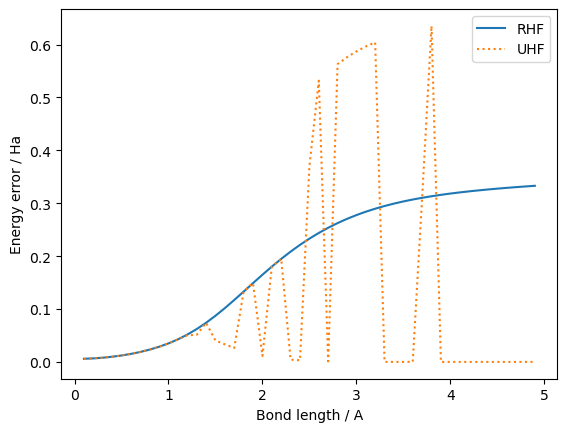

In [29]:
from matplotlib import pyplot as plt

rhf_energies = np.array(rhf_energies)
uhf_energies = np.array(uhf_energies)
mixed_energies = np.array(uhf_energies_mixed)
fci_energies = np.array(fci_energies)

rhf_err = rhf_energies - fci_energies
uhf_err = uhf_energies - fci_energies
mix_err = mixed_energies - fci_energies

plt.plot(bond_lengths, rhf_err, label="RHF")
plt.plot(bond_lengths, mix_err, ':', label="UHF")
plt.legend()
plt.xlabel("Bond length / A")
plt.ylabel("Energy error / Ha")
plt.show()

In [25]:
import numpy as np
from scipy.linalg import expm
from pyscf import gto, scf, fci

rhf_energies = []
uhf_energies = []
uhf_energies_mixed = []
fci_energies = []

angles = np.arange(0, 2, 0.05)

for angle in angles:
    mol = gto.Mole()
    mol.atom = f"H 0 0 0; H 0 0 6"    # in Angstrom by default
    mol.basis = "STO-3G"
    mol.charge = 0
    mol.spin = 0   # number of unpaired electrons: 0 => singlet (default)
    mol.verbose = 0
    mol.build()

    mf_rhf = scf.RHF(mol)
    rhf_energies.append(mf_rhf.kernel())

    mf_uhf = scf.UHF(mol)
    uhf_energies.append(mf_uhf.kernel())

    ca = mf_uhf.mo_coeff[0]
    cb = mf_uhf.mo_coeff[1]
    # print(ca)
    # print(cb)

    q = expm(np.array([[0, -angle], [angle, 0]]))
    ca = ca @ q
    cb = cb @ q.T
    # print(ca)
    # print(cb)

    mf_uhf.mo_coeff = [ca, cb]
    mf_uhf.verbose = 3
    uhf_energies_mixed.append(mf_uhf.kernel())
    # print(mf_uhf.mo_coeff)

    cisolver = fci.FCI(mol, mf_rhf.mo_coeff)
    fci_energy = cisolver.kernel()[0]
    fci_energies.append(fci_energy)


converged SCF energy = -0.589971420712877  <S^2> = -8.8817842e-16  2S+1 = 1
SCF not converged.
SCF energy = -0.421012281990881 after 50 cycles  <S^2> = 2.5845992e-13  2S+1 = 1
SCF not converged.
SCF energy = -0.586969069388028 after 50 cycles  <S^2> = -4.4408921e-16  2S+1 = 1
SCF not converged.
SCF energy = -0.246754001417519 after 50 cycles  <S^2> = -4.4408921e-16  2S+1 = 1
SCF not converged.
SCF energy = -0.470042221194235 after 50 cycles  <S^2> = 1.4876989e-14  2S+1 = 1
SCF not converged.
SCF energy = -0.24681665397546 after 50 cycles  <S^2> = -4.4408921e-16  2S+1 = 1
converged SCF energy = -0.246753957265093  <S^2> = -8.8817842e-16  2S+1 = 1
converged SCF energy = -0.246753957372626  <S^2> = -8.8817842e-16  2S+1 = 1
converged SCF energy = -0.246753957434972  <S^2> = -8.8817842e-16  2S+1 = 1
converged SCF energy = -0.246753957471169  <S^2> = -8.8817842e-16  2S+1 = 1
converged SCF energy = -0.246753957492249  <S^2> = -4.4408921e-16  2S+1 = 1
converged SCF energy = -0.246753957504378 

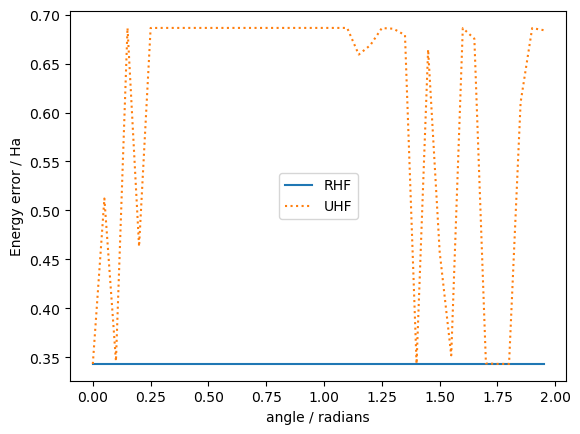

In [26]:
from matplotlib import pyplot as plt

rhf_energies = np.array(rhf_energies)
uhf_energies = np.array(uhf_energies)
mixed_energies = np.array(uhf_energies_mixed)
fci_energies = np.array(fci_energies)

rhf_err = rhf_energies - fci_energies
uhf_err = uhf_energies - fci_energies
mix_err = mixed_energies - fci_energies

plt.plot(angles, rhf_err, label="RHF")
plt.plot(angles, mix_err, ':', label="UHF")
plt.legend()
plt.xlabel("angle / radians")
plt.ylabel("Energy error / Ha")
plt.show()

In [16]:
import numpy as np
from scipy.linalg import expm
from pyscf import gto, scf

# Empty lists to store results
rhf_energies = []
uhf_energies_mixed = []
fci_energies = []

# UHF mixing angle and hydrogen bond lengths to iterate over
angles = np.linspace(0, 0.5, 101) * np.pi
bond_lengths = np.linspace(2, 4, 101)

# Create a mesh of each unique x, y pair
# The x-axis is mixing angle, the y-axis is bond length
X, Y = np.meshgrid(bond_lengths, angle)

# Calculate RHF and mixed UHF scanning over angles and bond lengths
for bond_length, angle in zip(X.ravel(), Y.ravel()):
    print(f"angle, length: {angle:.2f}, {bond_length:.2f}")
    mol = gto.Mole()
    mol.atom = f"H 0 0 0; H 0 0 {bond_length}"    # in Angstrom by default
    mol.basis = "STO-3G"
    mol.charge = 0
    mol.spin = 0   # number of unpaired electrons: 0 is singlet (default)
    # mol.verbose = 0
    mol.build()

    # Run restricted Hartree-Fock and store the energy
    mf_rhf = scf.RHF(mol)
    mf_rhf.verbose = 0
    rhf_energies.append(mf_rhf.kernel())

    # Run the unrestricted Hartree-Fock object
    mf_uhf = scf.UHF(mol)
    mf_uhf.verbose = 0
    mf_uhf.kernel()

    # Collect alpha/beta spins molecular orbital coeff matrices
    ca = mf_uhf.mo_coeff[0]
    cb = mf_uhf.mo_coeff[1]

    # Create rotation matrix and rotate coeff matrices
    q = expm(np.array([[0, -angle], [angle, 0]]))
    ca = ca @ q
    cb = cb @ q.T

    mf_uhf.mo_coeff = [ca, cb]
    mf_uhf.verbose = 0
    uhf_energies_mixed.append(mf_uhf.kernel())

angle, length: 0.00, 2.00
angle, length: 0.02, 2.00
angle, length: 0.03, 2.00
angle, length: 0.05, 2.00
angle, length: 0.06, 2.00
angle, length: 0.08, 2.00
angle, length: 0.09, 2.00
angle, length: 0.11, 2.00
angle, length: 0.13, 2.00
angle, length: 0.14, 2.00
angle, length: 0.16, 2.00
angle, length: 0.17, 2.00
angle, length: 0.19, 2.00
angle, length: 0.20, 2.00
angle, length: 0.22, 2.00
angle, length: 0.24, 2.00
angle, length: 0.25, 2.00
angle, length: 0.27, 2.00
angle, length: 0.28, 2.00
angle, length: 0.30, 2.00
angle, length: 0.31, 2.00
angle, length: 0.33, 2.00
angle, length: 0.35, 2.00
angle, length: 0.36, 2.00
angle, length: 0.38, 2.00
angle, length: 0.39, 2.00
angle, length: 0.41, 2.00
angle, length: 0.42, 2.00
angle, length: 0.44, 2.00
angle, length: 0.46, 2.00
angle, length: 0.47, 2.00
angle, length: 0.49, 2.00
angle, length: 0.50, 2.00
angle, length: 0.52, 2.00
angle, length: 0.53, 2.00
angle, length: 0.55, 2.00
angle, length: 0.57, 2.00
angle, length: 0.58, 2.00
angle, lengt

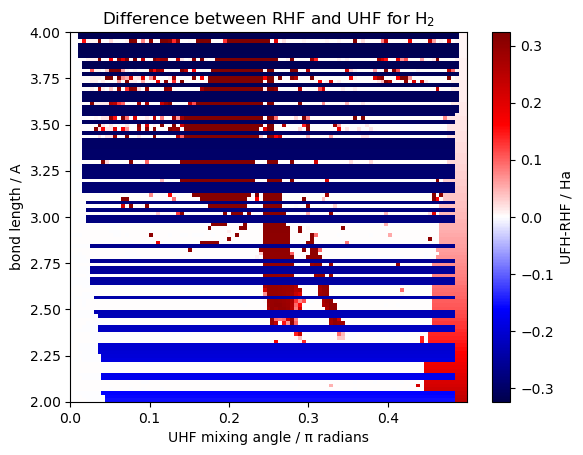

In [17]:
from matplotlib import pyplot as plt

rhf_energies = np.array(rhf_energies)
mixed_energies = np.array(uhf_energies_mixed)
fci_energies = np.array(fci_energies)

uhf_rhf_diff = mixed_energies - rhf_energies
uhf_rhf_diff = uhf_rhf_diff.reshape(X.shape)

angles_per_pi = angles / np.pi

# Plot heatmap of difference between RHF and UHF
plt.imshow(
    uhf_rhf_diff,
    # extent=[bond_lengths.min(), bond_lengths.max(), angles_per_pi.min(), angles_per_pi.max()],
    extent=[angles_per_pi.min(), angles_per_pi.max(), bond_lengths.min(), bond_lengths.max()],
    origin='lower',
    cmap='seismic',
    vmin=-np.max(abs(uhf_rhf_diff)),  # force symmetric colour scale which gives
    vmax= np.max(abs(uhf_rhf_diff)),  # different colours for positive and negative values
    aspect='auto',
)

plt.colorbar(label="UFH-RHF / Ha")
# plt.xlabel("bond length / A")
# plt.ylabel("UHF mixing angle / π radians")
plt.ylabel("bond length / A")
plt.xlabel("UHF mixing angle / π radians")
plt.title("Difference between RHF and UHF for H$_2$")
plt.show()

In [22]:
import pickle
with open("rhf_uhf/data.pkl", "wb") as f:
    pickle.dump((fci_energies, rhf_energies, mixed_energies), f)